# Demo for OT-Guided Conditional Score-Based Diffusion Model

A demo for optimal transport guided conditional score-based diffusion model. This demoe is for unpaired setting.

## Data Generation

For training, set ''training=Ture''. For test only, set ''training=False''.

In [1]:
training = True

In [2]:
import os
import numpy as np
import torch
from scipy import stats
import matplotlib.pyplot as plt
import torch.nn as nn
import itertools
import tqdm
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

/home/sun_guxiang/anaconda3/envs/torch1.12/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Generate the training data. We take the 1-dimensional case as an example. The source and target distributions are respectively $p(\mathbf{x})=\mathcal{N}(\mathbf{x};-4,1), q(\mathbf{y})=\mathcal{N}(\mathbf{y};4,1)$.

In [4]:
def generate_samples(mean=0.,size=32):
    data = stats.norm.rvs(loc=mean,size=size)
    # data = data + mean
    return data

### Visialize samples

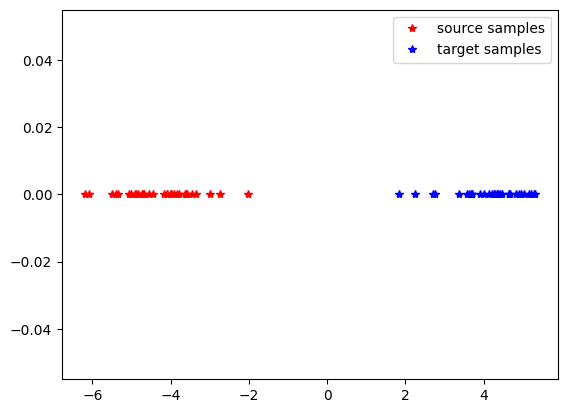

In [5]:
%matplotlib inline
source_mean = -4
target_mean = 4
source_samples = generate_samples(mean=source_mean)
target_samples = generate_samples(mean=target_mean)
plt.plot(source_samples,np.zeros_like(source_samples),"r*")
plt.plot(target_samples,np.zeros_like(target_samples),"b*")
plt.legend(["source samples","target samples"])
plt.show()

In [6]:
def compute_pdf(mean=0):
    min = -2.5*abs(mean)
    max = 2.5*abs(mean)
    x = np.linspace(min,max,100)
    pdf = stats.norm.pdf(x,loc=mean)
    return x,pdf

The probability density function of source and target distributions.

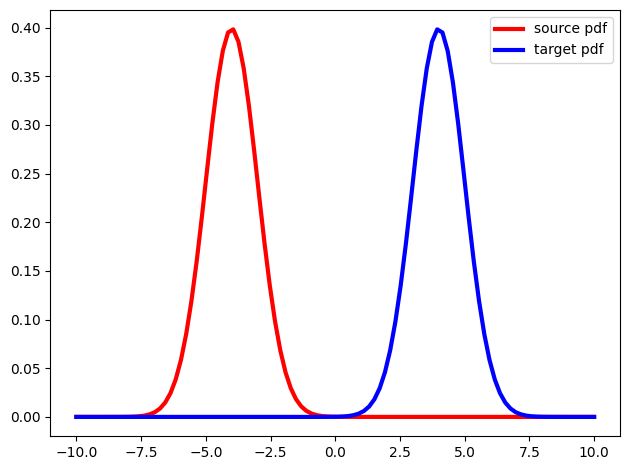

In [7]:
x,source_pdf = compute_pdf(source_mean)
x,target_pdf = compute_pdf(target_mean)
plt.plot(x,source_pdf,'r',linewidth=3)
plt.plot(x,target_pdf,'b',linewidth=3)
plt.tight_layout()
plt.legend(["source pdf","target pdf"])
plt.show()

Constructing the training data.


In [8]:
data_size = 10000
source_data = generate_samples(mean=source_mean,size=data_size)
target_data = generate_samples(mean=target_mean,size=data_size)

## Learning Poteintials of Dual Model

The unsupervised optimal transport model with $l_2$-regularization reads $$\min_{\pi}\int c(\mathbf{\mathbf{\mathbf{\mathbf{\mathbf{\mathbf{\mathbf{\mathbf{x}}}}}}}},\mathbf{y})\pi(\mathbf{\mathbf{\mathbf{x}}},\mathbf{y})\mathrm{d}\mathbf{x}\mathrm{d}\mathbf{y} + \epsilon \int \frac{\pi(\mathbf{x},\mathbf{y})^2}{p(\mathbf{x})q(\mathbf{y})}\mathrm{d}\mathbf{x}\mathrm{d}\mathbf{y} ,\\ s.t. \int\pi(\mathbf{x},\mathbf{y})\mathrm{d}\mathbf{y}=p(\mathbf{x}),\int\pi(\mathbf{x},\mathbf{y})\mathrm{d}\mathbf{x}=q(\mathbf{y}).$$ 
Dual formulation is $$\max_{u,v}\int u(\mathbf{x})q(\mathbf{x})\mathrm{d}\mathbf{x} + \int v(\mathbf{y})q(\mathbf{y})\mathrm{d}\mathbf{y} -\frac{1}{4\epsilon}\int[(u(\mathbf{x})+v(\mathbf{y})-c(\mathbf{x},\mathbf{y}))_+]^2p(\mathbf{x})q(\mathbf{y})\mathrm{d}\mathbf{x}\mathrm{d}\mathbf{y},$$ or equivalently, 
$$\max_{u,v}\mathbb{E}_{\mathbf{x}\sim p} u(\mathbf{x}) + \mathbb{E}_{\mathbf{y}\sim q} v(\mathbf{y}) -\frac{1}{4\epsilon}\mathbb{E}_{\mathbf{x}\sim p,\mathbf{y}\sim q}[(u(\mathbf{x})+v(\mathbf{y})-c(\mathbf{x},\mathbf{y}))_+]^2.$$
We represente $u,v$ with deep networks $u_{\omega},v_{\omega}$ and train $\omega$ using the dual objective function as loss.

Defining the cost matrix

In [9]:
def l2_cost(x,y):
    return (x.unsqueeze(1)-y.unsqueeze(0))**2

Objective function of dual model

In [10]:
def loss(u,v,C,reg):
    V = u.view(-1,1) + v.view(1,-1) - C
    loss = torch.mean(u) + torch.mean(v) - torch.mean(1/(4*reg)*torch.nn.functional.relu(V)**2)
    return -loss

Networks of potentials

In [11]:
u_net = nn.Sequential(nn.Linear(1,1024),nn.Tanh(),nn.Linear(1024,1)).to(device)
v_net = nn.Sequential(nn.Linear(1,1024),nn.Tanh(),nn.Linear(1024,1)).to(device)
# u_net = torch.nn.DataParallel(u_net)
# v_net = torch.nn.DataParallel(v_net)

Training function

In [12]:
def train(source_loader,target_loader,epsilon=1e-4,lr=1e-5,n_steps=300000):
    if epsilon <= 1e-5:
        n = np.log10(reg)
        reg_ = 10**(n+1)
        if os.path.exists(f"models/dual_model_{reg_}.pkl"):
            lr = 10**(n-1)
            dicts = torch.load(f"models/dual_model_{reg_}.pkl")
            u_net.load_state_dict(dicts["u_net"])
            v_net.load_state_dict(dicts["v_net"])
        else:
            raise(RuntimeError("Smaller epsilon should start from trained model of larger epsilon!")) 
    optimizer = torch.optim.Adam(itertools.chain(u_net.parameters(),v_net.parameters()),lr = lr)
    tqdm_range = tqdm.tqdm(range(n_steps))
    total_loss = 0

    for i in tqdm_range:
        try:
            xs,_ = source_iter.next()
        except:
            source_iter = iter(source_loader)
            xs,_ = source_iter.next()
        try:
            xt,_ = target_iter.next()
        except:
            target_iter = iter(target_loader)
            xt,_ = target_iter.next()   
        xs,xt = xs.to(device),xt.to(device) 
        u = u_net(xs.view(-1,1))
        v = v_net(xt.view(-1,1))
        C = l2_cost(xs,xt)
        l = loss(u,v,C,reg=epsilon)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        total_loss += l
        tqdm_range.set_description(f"loss:{total_loss.item()/(i+1)}")
        if (i+1) %10000 == 0:
            if not os.path.exists("models"):
                os.makedirs("models")
            torch.save({"u_net":u_net.state_dict(),"v_net":v_net.state_dict()},
                    f"models/potentials_{epsilon}.pkl")

The training config.

In [13]:
epsilon = 1e-4
learning_rate = 1e-5
batch_size = 64

Building dataset and dataloader.

In [14]:
from torch.utils.data import DataLoader,TensorDataset
source_dataset = TensorDataset(torch.Tensor(source_data),torch.Tensor(source_data))
target_dataset = TensorDataset(torch.Tensor(target_data),torch.Tensor(target_data))
source_loader = DataLoader(source_dataset,batch_size=batch_size,shuffle=True,drop_last=True)
target_loader = DataLoader(target_dataset,batch_size=batch_size,shuffle=True,drop_last=True)

Training

In [15]:

if training:
    train(source_loader,target_loader,epsilon=epsilon,lr=learning_rate) 

loss:-60.402946666666665: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 300000/300000 [14:09<00:00, 353.15it/s]


After training, the learned parameters are denoted $\hat{\omega}$. The transport plan is computed by 
$$\hat{\pi}(\mathbf{x},\mathbf{y})=\frac{1}{2\epsilon}(u_{\hat{\omega}}(\mathbf{x})+v_{\hat{\omega}}(\mathbf{y})-c(\mathbf{x},\mathbf{y}))_+p(\mathbf{x})q(\mathbf{y}) = H(\mathbf{x},\mathbf{y})p(\mathbf{x})q(\mathbf{y})$$
Conditional transport plan is
$$\hat{\pi}(\mathbf{y}|\mathbf{x})=H(\mathbf{x},\mathbf{y})q(\mathbf{y}).$$

In [16]:
dicts = torch.load(f"models/potentials_{epsilon}.pkl",map_location=device)
u_net.load_state_dict(dicts["u_net"])
v_net.load_state_dict(dicts["v_net"])

<All keys matched successfully>

In [17]:
def computing_H(xt,xs,u_net,v_net,epsilon):
    C = l2_cost(xs,xt)
    u = u_net(xs.view(-1,1))
    v = v_net(xt.view(-1,1)).view(1,-1)
    V = torch.nn.functional.relu(u+v-C)
    h = 1/(2*epsilon)*V
    return h

We show $\hat{\pi}(\mathbf{y}|\mathbf{x}=-4)$.

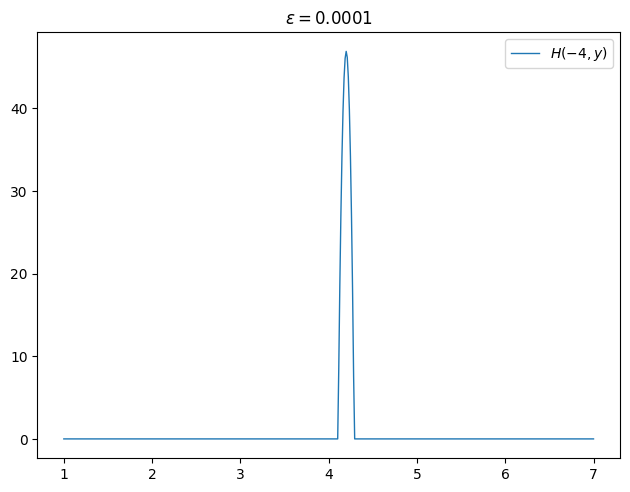

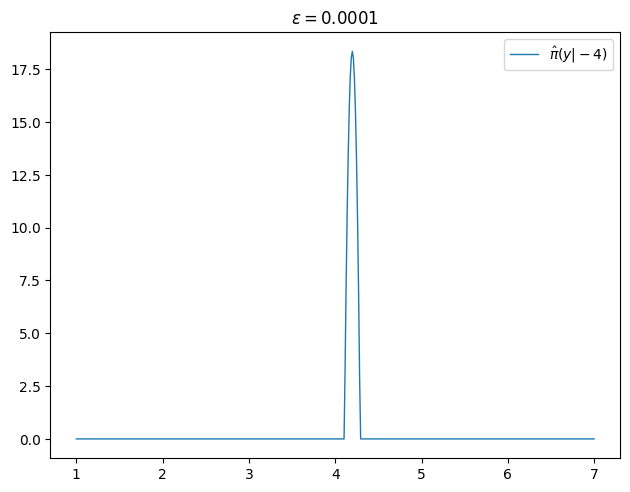

In [18]:
xt_ = np.linspace(target_mean-3,target_mean+3,500)
xt = torch.Tensor(xt_).to(device)
xs = torch.Tensor([source_mean]).to(device)
h = computing_H(xt,xs, u_net,v_net,epsilon)[0].cpu().data.numpy()
plt.figure()
plt.plot(xt_,h,linewidth=1)
plt.tight_layout()
plt.title(f"$\epsilon=${epsilon}")
plt.legend([r"$H(-4,y)$"])

pi_y_x = stats.norm.pdf(xt_,loc=target_mean)*h
plt.figure()
plt.plot(xt_,pi_y_x,linewidth=1)
plt.tight_layout()
plt.legend([r"$\hat{\pi}(y|-4)$"])
plt.title(f"$\epsilon=${epsilon}")

plt.show()

## OT-Guided Conditional Score-Based Diffusion Model

To learn the conditional score-based model $s_{\theta}(\mathbf{y};\mathbf{x},t)$, based on Theorem 1 in the paper, we 
first introduce the forwar process
$$\mathrm{d}\mathbf{y}_t = f(\mathbf{y}_t,t)\mathrm{d}t + g(t)\mathrm{d}\mathbf{w}, \mathbf{y}_0\sim\hat{\pi}(\mathbf{y}|\mathbf{x})$$
where $f(\mathbf{y},t)=0,g(t)=\alpha^t$ in this demo.
Then the pdf of $\mathbf{y}_t$ given $\mathbf{y}_0$ is 
$$p_{t|0}(\mathbf{y}_t|\mathbf{y}_0,\mathbf{x})=\mathcal{N}\bigg(\mathbf{y}_t; \mathbf{y}_0, \frac{1}{2\log \sigma}(\sigma^{2t} - 1)\bigg), p_t(\mathbf{y}|\mathbf{x}) = \int \hat{\pi}(\mathbf{y}|\mathbf{x}) p_{t|0}(\mathbf{y}|\mathbf{y}_0,\mathbf{x})\mathrm{d}\mathbf{y}_0.$$
<!-- When $\sigma$ is large, the prior distribution, $p_{1}(\mathbf{y}|\mathbf{x})$ is 
\begin{align*}
\int q(\mathbf{y}_0)\mathcal{N}\bigg(y_1; \mathbf{y}_0, \frac{1}{2 \log \sigma}(\sigma^2 - 1)\bigg) \mathrm{d}\mathbf{y}_0 \approx \mathcal{N}\bigg(y_1; 0, \frac{1}{2 \log \sigma}(\sigma^2 - 1)\bigg),
\end{align*}
which is approximately independent of the data distribution and is easy to sample from. -->

The std and diffusion coefficient functions are 

In [19]:
sigma = 25.0
def marginal_prob_std(t, sigma=sigma):
    t = torch.tensor(t).to(device)
    return torch.sqrt((sigma ** (2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma=sigma):
    return torch.tensor(sigma ** t).to(device)

The conditional score model $s_{\theta}(\mathbf{y};\mathbf{x},t)$ is to match the gradient of $p_t(\mathbf{y}|\mathbf{x})$ by conditional denoising score matching 
<!-- $$\min_{\omega}\mathcal{J}_{CSM}\\ \mathcal{J}_{CSM} = \int_0^1\lambda(t)E_{x\sim p(x)}E_{y\sim p_{t}(y|x)}\Vert s_{\theta}(\mathbf{y};\mathbf{x},t) -\nabla_{\mathbf{y}_t} \log p_{t}(y|x)\Vert_2^2\mathrm{d}t.$$
This can be realized by conditioanl denoising score matching as 
$$\min_{\omega}\mathcal{J}_{CDSM}\\ \mathcal{J}_{SM} = \int_0^1\lambda(t)E_{x\sim p(x)}E_{\mathbf{y}_0\sim \pi_{\hat{\omega}}^{\epsilon}(y|x)} E_{\mathbf{y}_t\sim p_{t|0}(\mathbf{y}_t|\mathbf{y}_0)}\Vert s_{\theta}(\mathbf{y}_t;x,t) -\nabla_{\mathbf{y}_t} \log p_{t|0}(\mathbf{y}_t|\mathbf{y}_0,x)\Vert_2^2\mathrm{d}t.$$
Further -->
$$\mathcal{J}_{\rm CDSM} =  \mathbb{E}_{t}w_t\mathbb{E}_{\mathbf{x}\sim p(\mathbf{x}),\mathbf{y}_0\sim q(\mathbf{y})} H(\mathbf{x},\mathbf{y}_0)\mathbb{E}_{\mathbf{y}_t\sim p_{t|0}(\mathbf{y}_t|\mathbf{y}_0)}\Vert s_{\theta}(\mathbf{y}_t;\mathbf{x},t) -\nabla_{\mathbf{y}_t} \log p_{t|0}(\mathbf{y}_t|\mathbf{y}_0,\mathbf{x})\Vert_2^2.$$
Directly implementing $\mathcal{J}_{\rm CDSM}$ for given $t$ using mini-batch data can cause unstable training due to the sparsity of $H$. We present the following "Resampling-by-compatibility" technique (see Algorithm 2):
* For each $\mathbf{x}^i$ in source dataset, we compute and store the target samples (indexes) satisfying that $H>0$, i.e., storing the dict of non-zero $H$: $Dict=\{i:(\{j|H(\mathbf{x}^i,\mathbf{y}^j)>0\}, \{H(\mathbf{x}^i,\mathbf{y}^j)|H(\mathbf{x}^i,\mathbf{y}^j)>0\})\}$.
* In each training step, we randomly choose a source index $i$, then find the element $D = Dict[i]$ and choose a index $j$ from $D[0]$ with probability propotional to $D[1]$. Finally, we load the images $\mathbf{x}^i$ and $\mathbf{y}^j$ and feed them to the network to calculate the loss 
$$\mathcal{J}_{\mathbf{x}^i,\mathbf{y}^j}=\mathbb{E}_{t}w_t\mathbb{E}_{\mathbf{y}_t\sim p_{t|0}(\mathbf{y}_t|\mathbf{y}^j)}\Vert s_{\theta}(\mathbf{y}_t;\mathbf{x}^i,t) -\nabla_{\mathbf{y}_t} \log p_{t|0}(\mathbf{y}_t|\mathbf{y}^j,\mathbf{x}^i)\Vert_2^2.$$

<!-- to update the networks. -->
<!-- Because for given $x_0$, only a few $y$ are with non-zero $H(x_0,y)$, and thus few samples contribute to the training loss.
To train with mini-batch data, we first sample $x$ from $p$, sample $\{y^l\}_{l=1}^L$ from $q$, then choose a $\mathbf{y}_0$ from $\{y^l\}_{l=1}^L$ with probability propotional to $H(x,y^l)$. Finaly, the sampled $x,\mathbf{y}_0$ are used to cumpute the denoising score matching loss
$$E_{\mathbf{y}_t\sim p_{t|0}(\mathbf{y}_t|\mathbf{y}_0)}\Vert s_{\theta}(\mathbf{y}_t;x,t) -\nabla_{\mathbf{y}_t} \log p_{t|0}(\mathbf{y}_t|\mathbf{y}_0,x)\Vert_2^2.$$
The rationality is as follows.
For large $L$, $q(y)$ can be well approximated by $q(y)=\frac{1}{L}\sum_{l=1}^L\delta_{y^l}(y)$. For any function $F$, we have 
$$\min E_{y\sim q(y)}[H(x,y)F(y)]\approx \min \frac{1}{L}\sum_{l=1}^L H(x,y^l)F(y^l) 
\Longleftrightarrow  \min \sum_{l=1}^L \frac{H(x,y^l)}{\sum_{l=1}^L H(x,y^l)}F(y^l) = \min E_{y\sim \tilde{q}(y)}[F(y)]$$
where $\tilde{q}(y)=\sum_{l=1}^L h^l \delta_{y^l}(y), h^l=\frac{H(x,y^l)}{\sum_{l=1}^L H(x,y^l)}$.  -->

<!-- Since $p_{t|0}(\mathbf{y}_t|\mathbf{y}_0,x)$ is normal distribution, the denoising score matching loss is equivelent to 
$$E_{z\sim \mathcal{N}(0,1)}\Vert s_{\theta}(\mathbf{y}_0 + \alpha z;x,t) *\alpha + z\Vert_2^2,$$
where $\alpha$ is the std of $p_{t|0}(\mathbf{y}_t|\mathbf{y}_0,x)$ given before.

Denoising score matching loss -->

Storing the dict

In [20]:
### compute and save the potentials
def save_potentials():
    source_potentials = compute_potentials(source_dataset, u_net)
    target_potentials = compute_potentials(target_dataset, v_net)
    return source_potentials, target_potentials

def compute_potentials(dataset,net):
    loader = torch.utils.data.DataLoader(dataset,batch_size=256)
    P = []
    import tqdm
    with torch.no_grad():
        for x,_ in tqdm.tqdm(loader):
            x = x.cuda().view(len(x),-1)
            P.append(net(x))
        P = torch.cat(P,dim=0)
    return P

#### save dict
def save_dict():
    us,vs = save_potentials()
    Xs = torch.Tensor(source_data).cuda()
    Xt = torch.Tensor(target_data).cuda()
    def computing_H_(i):
        x = Xs[[i]]
        C = l2_cost(x,Xt)
        u = us[i]
        V = torch.nn.functional.relu(u+vs.view(1,-1)-C)
        h = 1/(2*epsilon)*V
        return h
    dicts = {}
    for i in tqdm.trange(len(source_dataset)):
        h = computing_H_(i).cpu().view(-1,)
        index = (h>0.1).nonzero(as_tuple=False).view(-1,)
        h_ = h[index]
        dicts[i] = (index.numpy(),h_.numpy())
    torch.save(dicts,f"models/non_zero_dict_{epsilon}.pkl")

save_dict()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 2834.93it/s]


Dataloader for training the score-based model.

In [21]:
from torch.utils.data import Dataset
class PairedDataset(Dataset):
    def __init__(self,source_dataset,target_dataset,file_root="models",epsilon=1e-4):
        self.load_OT(file_root,epsilon)
        self.source_dataset = source_dataset
        self.target_dataset = target_dataset

    def load_OT(self,file_root,epsilon):
        self.non_zero_dict = torch.load(os.path.join(file_root,f"non_zero_dict_{epsilon}.pkl"))

    def __getitem__(self, source_index):
        non_zero_indexes,values = self.non_zero_dict[source_index]
        if len(non_zero_indexes) == 0: 
            returns = self.__getitem__((source_index+1)%self.__len__())
            return returns
        else:
            values = values/values.sum()
            target_index = np.random.choice(non_zero_indexes,p=values)
            xs,_= self.source_dataset[source_index]
            xt,_ = self.target_dataset[target_index]
            
            return xs,xt

    def __len__(self):
        return len(self.non_zero_dict)

Given the sampled $\mathbf{x}$, $\mathbf{y}$ from the Resampling-by-compatibility, since $p_{t|0}(\mathbf{y}_t|\mathbf{y}_0,\mathbf{x})$ is normal distribution, the denoising score matching loss is equivelent to 
$$\mathcal{J}_{\mathbf{x},\mathbf{y}} = \mathbb{E}_t\frac{w_t}{\sigma_t^2}\mathbb{E}_{\mathbf{z}\sim \mathcal{N}(0,1)}\Vert s_{\theta}(\mathbf{y}_0 + \sigma_t \mathbf{z};\mathbf{x},t) *\sigma_t + \mathbf{z}\Vert_2^2,$$
where $\sigma_t$ is the std of $p_{t|0}(\mathbf{y}_t|\mathbf{y}_0,\mathbf{x})$ given before.

In [22]:
def loss_fn(model, x, xs, marginal_prob_std, eps=1e-5):
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
    z = torch.randn_like(x)
    std = marginal_prob_std(random_t)
    perturbed_x = x + z * std[:, None]
    score = model(perturbed_x, random_t,xs)
    loss = torch.mean(torch.sum((score * std[:, None] + z) ** 2, dim=-1))
    return loss

Architecture of $s_{\theta}(\mathbf{y}_t;x,t)$

In [23]:
from copy import deepcopy
from collections import OrderedDict

#EMA is for moving average
class EMA(nn.Module):
    def __init__(self, model: nn.Module, decay: float):
        super().__init__()
        self.decay = decay

        self.model = model
        self.shadow = deepcopy(self.model)

        for param in self.shadow.parameters():
            param.detach_()

    @torch.no_grad()
    def update(self):
        if not self.training:
            print("EMA update should only be called during training", file=stderr, flush=True)
            return

        model_params = OrderedDict(self.model.named_parameters())
        shadow_params = OrderedDict(self.shadow.named_parameters())

        # check if both model contains the same set of keys
        assert model_params.keys() == shadow_params.keys()

        for name, param in model_params.items():
            shadow_params[name].sub_((1. - self.decay) * (shadow_params[name] - param))

        model_buffers = OrderedDict(self.model.named_buffers())
        shadow_buffers = OrderedDict(self.shadow.named_buffers())

        # check if both model contains the same set of keys
        assert model_buffers.keys() == shadow_buffers.keys()

        for name, buffer in model_buffers.items():
            # buffers are copied
            shadow_buffers[name].copy_(buffer)

    def forward(self, inputs: torch.Tensor,training=True) -> torch.Tensor:
        if training:
            return self.model(inputs)
        else:
            return self.shadow(inputs)

class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.dense(x)[:, None]
    
class ConditionalScoreNet(nn.Module):
    def __init__(self, marginal_prob_std,hidden_dim = 512, embed_dim=256):
        super().__init__()
        # Gaussian random feature embedding layer for time
        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
                                   nn.Linear(embed_dim, embed_dim),
                                   nn.SiLU(),
                                   nn.Linear(embed_dim,hidden_dim))
        # source embedding bloack                            
        self.source_embed = nn.Sequential(nn.Linear(1, 1024), nn.SiLU(),
                                          nn.Linear(1024, 1024), nn.SiLU(),
                                          nn.Linear(1024, hidden_dim)
                                          )
        self.linear1 = nn.Linear(1,hidden_dim)
        self.linear2 = nn.Linear(hidden_dim,hidden_dim)
        self.linear3 = nn.Linear(hidden_dim,1)

        self.act = nn.SiLU()
        self.marginal_prob_std = marginal_prob_std

    def forward(self, x, t, xs):
        # Obtain the Gaussian random feature embedding for t and source embedding
        embed = self.embed(t) + self.source_embed(xs)
        # Encoding path
        h1 = self.act(self.linear1(x)+embed)
        h2 = self.act(self.linear2(h1)+embed)
        h = self.linear3(h2)

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None]
        return h


In [24]:
score_model = ConditionalScoreNet(marginal_prob_std=marginal_prob_std)
score_model = score_model.to(device)
score_model_ = EMA(score_model,decay=0.999)
n_steps = 50000
batch_size = 64
lr=1e-4
x0 = torch.Tensor([-4.0]).to(device)
dicts = torch.load(f"models/potentials_{epsilon}.pkl",map_location=device)
u_net.load_state_dict(dicts["u_net"])
v_net.load_state_dict(dicts["v_net"])

<All keys matched successfully>

Training function

In [29]:
def train_score_model():
    optimizer = torch.optim.Adam(score_model.parameters(), lr=lr)
    dataset = PairedDataset(source_dataset,target_dataset,epsilon=epsilon)
    dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=True,drop_last=True)
    tqdm_steps = tqdm.trange(n_steps)
    for step in tqdm_steps:
        try:
            xs,xt = data_iter.next()
        except:
            data_iter = iter(dataloader)
            xs,xt = data_iter.next()
        xs,xt = xs.cuda().view(-1,1),xt.cuda().view(-1,1)
        loss = loss_fn(score_model, xt, xs, marginal_prob_std)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        score_model_.update()
        tqdm_steps.set_description('Average Loss: {:5f}'.format(loss.item()))
        if step % 1000 == 0:
            torch.save(score_model_.shadow.state_dict(), f'models/score_{epsilon}.pth')
            # if not os.path.exists("samples"):
            #     os.makedirs("samples")
            # with torch.no_grad():
            #     samples = sampling(score_model_.shadow,x0,batch_size=1024)
            #     samples = samples.cpu().view(-1,).numpy()
            #     plt.figure()
            #     plt.hist(samples,bins=100)
            #     plt.plot(samples,0*np.ones_like(samples),"*")
            #     plt.xlim([0, 8])
            #     plt.show()
            #     plt.close()

Reverse SDE 
$$\mathrm{d}\mathbf{y}_t = \big(f(\mathbf{y}_t,t)-g^2(t) \nabla_{\mathbf{y}_t} p_t(\mathbf{y}_t|\mathbf{x})\big)\mathrm{d}t + g(t) \mathrm{d}\bar{\mathbf{w}}  \approx \big(f(\mathbf{y}_t,t)-g^2(t) s_{\theta}(\mathbf{y}_t;\mathbf{x},t)\big)\mathrm{d}t + g(t) \mathrm{d}\bar{\mathbf{w}}.$$



Sampling function (reverse sde)

In [30]:
def sampling(score_model,xs,batch_size=64,eps=1e-4,num_steps=1000):
    t_start = 1.0
    t = torch.ones(batch_size).to(device)* t_start
    init_x = torch.randn(batch_size, 1).to(device) * marginal_prob_std(t)[:,None]
    time_steps = np.linspace(t_start, eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    for time_step in tqdm.tqdm(time_steps):
        batch_time_step = torch.ones(batch_size).to(device) * time_step
        with torch.no_grad():
            grad = score_model(x, batch_time_step,xs*torch.ones_like(x))
        g = diffusion_coeff(batch_time_step)
        x_mean = x + 1.0 * (g ** 2)[:, None] * grad * step_size
        x = x_mean + torch.sqrt(g ** 2 * step_size)[:, None] * torch.randn_like(x)
    return x_mean.data

Training score model

In [31]:
if training:
    train_score_model()

  0%|                                                                                                                                  | 0/50000 [00:00<?, ?it/s]/tmp/ipykernel_171842/3157621311.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t).to(device)
Average Loss: 0.006098: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [04:33<00:00, 183.09it/s]


Visialize hist of generated samples

In [32]:
score_model.load_state_dict(torch.load(f'models/score_{epsilon}.pth',map_location=device))
with torch.no_grad():
    samples = sampling(score_model, x0, batch_size=1024,num_steps=1000)
    samples = samples.cpu().view(-1, ).numpy()

/tmp/ipykernel_171842/3157621311.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t).to(device)
  0%|                                                                                                                                   | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_171842/3157621311.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma ** t).to(device)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 645.42it/s]


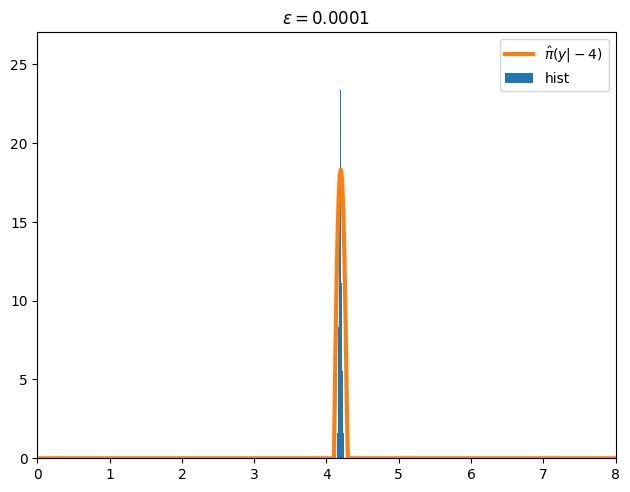

In [33]:
plt.figure()
plt.hist(samples, bins=50,density=True)
plt.xlim([0, 8])

xt_ = np.linspace(target_mean-4,target_mean+4,500)
xt = torch.Tensor(xt_).to(device)
h = computing_H(xt,x0, u_net,v_net,epsilon)[0].cpu().data.numpy()
pi_y_x = stats.norm.pdf(xt_,loc=target_mean)*h
plt.plot(xt_,pi_y_x,linewidth=3)
plt.tight_layout()
plt.legend([r"$\hat{\pi}(y|-4)$","hist"])
plt.title(f"$\epsilon=${epsilon}")
plt.show()

In [34]:
mu_sde = np.mean(samples)
sigma_sde = np.mean((samples-mu_sde)**2)

mu_hat = np.sum(pi_y_x*xt_)/np.sum(pi_y_x)
sigma_hat = np.sum(pi_y_x*(xt_-mu_hat)**2)/np.sum(pi_y_x)

disp = (mu_hat-mu_sde)**2 + (sigma_sde**0.5-sigma_hat**0.5)**2
print(disp,mu_hat,sigma_hat**0.5,mu_sde,sigma_sde**0.5)

0.0005995491691643257 4.198142498018012 0.04121512132778964 4.1912293 0.017725603184805372
